In [1]:
!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 16.8 MB/s eta 0:00:00


In [2]:
%mkdir -p /content/sher

In [3]:
!git clone https://github.com/amnghd/Persian_poems_corpus.git

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 15.49 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
%mv /content/Persian_poems_corpus/original/abusaeed.txt /content/sher/abusaeed.txt
%mv /content/Persian_poems_corpus/original/babaafzal.txt /content/sher/babaafzal.txt
%mv /content/Persian_poems_corpus/original/bahaee.txt /content/sher/bahaee.txt
%mv /content/Persian_poems_corpus/original/gilani.txt /content/sher/gilani.txt
%mv /content/Persian_poems_corpus/original/hatef.txt /content/sher/hatef.txt
%mv /content/Persian_poems_corpus/original/helali.txt /content/sher/helali.txt
%mv /content/Persian_poems_corpus/original/khayyam.txt /content/sher/khayyam.txt
%mv /content/Persian_poems_corpus/original/asad.txt /content/sher/asad.txt
%mv /content/Persian_poems_corpus/original/khosro.txt /content/sher/khosro.txt
%mv /content/Persian_poems_corpus/original/onsori.txt /content/sher/onsori.txt

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections

In [6]:
%cd /content/sher
files = os.listdir()

/content/sher


In [7]:
files.remove('.ipynb_checkpoints')

ValueError: ignored

In [8]:
files

['onsori.txt',
 'asad.txt',
 'khosro.txt',
 'hatef.txt',
 'gilani.txt',
 'abusaeed.txt',
 'helali.txt',
 'khayyam.txt',
 'bahaee.txt',
 'babaafzal.txt']

In [9]:
def readData(file_name,l):
  data = pd.read_csv(file_name, sep="\n")
  data.drop(0, axis=0, inplace=True)
  data['label'] = l
  data.rename(columns={file_name: 'poem'}, inplace=True)
  return data

In [10]:
df = pd.DataFrame()
l=0
dic1={}
dic2={}

for file_name in files:
  poet_name = file_name.split(".")[0]
  data = readData(file_name,poet_name)
  dic1[l]=poet_name
  dic2[poet_name]=l
  df = pd.concat([df, data])
  l+=1

In [11]:
dic1

{0: 'onsori',
 1: 'asad',
 2: 'khosro',
 3: 'hatef',
 4: 'gilani',
 5: 'abusaeed',
 6: 'helali',
 7: 'khayyam',
 8: 'bahaee',
 9: 'babaafzal'}

In [12]:
df

,poem,label
1,دل مرا عجب آید همی ز کار هوا,onsori
2,که مشکبوی سلب شد ز مشکبوی صبا,onsori
3,ز رنگ و بوی همی دانم و ندانم از آنک,onsori
4,چنین هوا ز صبا گشت یا صبا ز هوا,onsori
5,درخت اگر علم پرنیان گشاد رواست,onsori
...,...,...
875,ز آن است گل و نرگس رخسار تو سیراب,babaafzal
876,کز دیده روان کرده ام از مهر تو صد جوی,babaafzal
877,تا بوک سزاوار شوی دیدن او را,babaafzal
878,ای دیده تو خود را به هزار آب همی شوی,babaafzal


In [13]:
df['poem_len'] = df['poem'].apply(lambda t: len(hazm.word_tokenize(t)))
df

,poem,label,poem_len
1,دل مرا عجب آید همی ز کار هوا,onsori,8
2,که مشکبوی سلب شد ز مشکبوی صبا,onsori,7
3,ز رنگ و بوی همی دانم و ندانم از آنک,onsori,10
4,چنین هوا ز صبا گشت یا صبا ز هوا,onsori,9
5,درخت اگر علم پرنیان گشاد رواست,onsori,6
...,...,...,...
875,ز آن است گل و نرگس رخسار تو سیراب,babaafzal,9
876,کز دیده روان کرده ام از مهر تو صد جوی,babaafzal,9
877,تا بوک سزاوار شوی دیدن او را,babaafzal,7
878,ای دیده تو خود را به هزار آب همی شوی,babaafzal,10


In [14]:
min_max_len = df['poem_len'].min(), df['poem_len'].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 1 	Max: 44


In [15]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df['poem_len']
))

fig.update_layout(
    title_text='Distribution of word counts within peoms',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [16]:
df['poem_len'] = df['poem_len'].apply(lambda len_t: len_t if 4 <= len_t <= 12 else None)
df = df.dropna(subset=['poem_len'])
df = df.reset_index(drop=True)

In [17]:
df

,poem,label,poem_len
0,دل مرا عجب آید همی ز کار هوا,onsori,8.0
1,که مشکبوی سلب شد ز مشکبوی صبا,onsori,7.0
2,ز رنگ و بوی همی دانم و ندانم از آنک,onsori,10.0
3,چنین هوا ز صبا گشت یا صبا ز هوا,onsori,9.0
4,درخت اگر علم پرنیان گشاد رواست,onsori,6.0
...,...,...,...
92911,ز آن است گل و نرگس رخسار تو سیراب,babaafzal,9.0
92912,کز دیده روان کرده ام از مهر تو صد جوی,babaafzal,9.0
92913,تا بوک سزاوار شوی دیدن او را,babaafzal,7.0
92914,ای دیده تو خود را به هزار آب همی شوی,babaafzal,10.0


In [18]:
train, test = train_test_split(df, test_size=0.1, random_state=1, stratify=df['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['poem'].values.tolist(), train['label'].values.tolist()
x_valid, y_valid = valid['poem'].values.tolist(), valid['label'].values.tolist()
x_test, y_test = test['poem'].values.tolist(), test['label'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(75261, 3)
(8363, 3)
(9292, 3)


In [19]:
train

,poem,label,poem_len
0,زمن بپذیر زینسان یادگاری,khosro,4.0
1,چو خالی دید کرد آفت سگالی,khosro,6.0
2,ور عطش فکر نبرد حریف,khosro,5.0
3,مگو دیده ست کس یا کس ندیده ست,khosro,8.0
4,سوگند خور تو همچون ما نیز بر همینیم,gilani,8.0
...,...,...,...
75256,جوابش داد ویس ماه رخسار,asad,5.0
75257,چون زمیان رفته حجاب خیال,khosro,5.0
75258,دلش خوش گشت لختی بر برادر,asad,6.0
75259,بگشاد زمام را به تندی,khosro,5.0


In [43]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW 
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [47]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 2
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [23]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(MODEL_NAME_OR_PATH, **{'label2id': dic2, 'id2label': dic1})

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "onsori",
    "1": "asad",
    "2": "khosro",
    "3": "hatef",
    "4": "gilani",
    "5": "abusaeed",
    "6": "helali",
    "7": "khayyam",
    "8": "bahaee",
    "9": "babaafzal"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "abusaeed": 5,
    "asad": 1,
    "babaafzal": 9,
    "bahaee": 8,
    "gilani": 4,
    "hatef": 3,
    "helali": 6,
    "khayyam": 7,
    "khosro": 2,
    "onsori": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



In [24]:
idx = np.random.randint(0, len(train))
sample_poem = train.iloc[idx]['poem']
sample_label = train.iloc[idx]['label']

print(f'Sample: \n{sample_poem}\n{sample_label}')

Sample: 
به کوه بیستون روزی گذر کرد
khosro


In [25]:
tokens = tokenizer.tokenize(sample_poem)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'   Poem: {sample_poem}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

   Poem: به کوه بیستون روزی گذر کرد
   Tokens: به کوه بیستون روزی گذر کرد
Token IDs: [2789, 4286, 19224, 6367, 5398, 2830]


In [26]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'poem': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [27]:
list(dic1.values())

['onsori',
 'asad',
 'khosro',
 'hatef',
 'gilani',
 'abusaeed',
 'helali',
 'khayyam',
 'bahaee',
 'babaafzal']

In [28]:
label_list = list(dic1.values())
MAX_LEN=12
train_data_loader = create_data_loader(train['poem'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['poem'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['poem'].to_numpy(), test['label'].to_numpy(), tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [29]:
train['poem'].to_numpy()

array(['زمن بپذیر زینسان یادگاری', 'چو خالی دید کرد آفت سگالی',
       'ور عطش فکر نبرد حریف', ..., 'دلش خوش گشت لختی بر برادر',
       'بگشاد زمام را به تندی', 'گفتم آن زلف سخت خوشبویست'], dtype=object)

In [30]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['poem'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['poem', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['زمن بپذیر زینسان یادگاری', 'چو خالی دید کرد آفت سگالی', 'ور عطش فکر نبرد حریف', 'مگو دیده ست کس یا کس ندیده ست', 'سوگند خور تو همچون ما نیز بر همینیم', 'لب شهر و دو مطرب زخمه درود', 'گر چه از شاخ جوانیت نخوردیم بری', 'شیران شکار، پاسبانش', 'کجا رسد مه گردون بدین قمر، باری', 'زان دهان کام منست و هست پنهان زیر لب', 'مرغ بیابان عشق خار مغیلان خورد', 'خلافست اینکه می گویند باشد آرزو در دل', 'در گوشه ای در گوش به تنهاش بگویی', 'که ناله های تو در سینه کار می کندم', 'از گل و سبزه عجایب چمنی ساخته اند', 'جویای رخ خوب جانانه توئی یا ما']
torch.Size([16, 12])
tensor([    2,  5297,  2011, 11269,  7946,  3321, 18158,     4,     0,     0,
            0,     0])
torch.Size([16, 12])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])
torch.Size([16, 12])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([16])
tensor(2)


In [31]:
sample_test = next(iter(test_data_loader))
print(sample_test.keys())

dict_keys(['poem', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])


In [32]:
class poetModel(nn.Module):

    def __init__(self, config):
        super(poetModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        logits = self.classifier(pooled_output[1])
        return logits 

In [33]:
pt_model = poetModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.poetModel'>


In [34]:
# sample data output

sample_data_comment = sample_data['poem']
sample_data_input_ids = sample_data['input_ids']
sample_data_attention_mask = sample_data['attention_mask']
sample_data_token_type_ids = sample_data['token_type_ids']
sample_data_targets = sample_data['targets']

# available for using in GPU
sample_data_input_ids = sample_data_input_ids.to(device)
sample_data_attention_mask = sample_data_attention_mask.to(device)
sample_data_token_type_ids = sample_data_token_type_ids.to(device)
sample_data_targets = sample_data_targets.to(device)


# outputs = F.softmax(
#     pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids), 
#     dim=1)

outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)
"""bertt = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
A=bertt(
            input_ids=sample_data_input_ids, 
            attention_mask=sample_data_attention_mask, 
            token_type_ids=sample_data_token_type_ids)
"""
print(outputs[:5, :])
print(preds[:5])

tensor([[-0.0589,  0.1890,  0.2129,  0.3901,  0.1142, -0.2406,  0.5144, -0.1078,
          0.4219,  0.1839],
        [-0.1940, -0.0730,  0.1170,  0.5195,  0.4289, -0.2858,  0.6506,  0.0220,
          0.5367,  0.2811],
        [-0.0667,  0.0373, -0.0145,  0.5646,  0.0869, -0.3507,  0.5132,  0.0312,
          0.2912,  0.3496],
        [-0.0035,  0.1347,  0.3421,  0.5602,  0.5130, -0.2784,  0.4535,  0.0442,
          0.4672,  0.4635],
        [ 0.1267, -0.0717,  0.0095,  0.5194,  0.2532, -0.3376,  0.3854,  0.0045,
          0.4298,  0.1795]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([6, 6, 3, 3, 3], device='cuda:0')


In [44]:
for param in pt_model.bert.parameters():
    param.requires_grad = False

In [45]:
for param in pt_model.classifier.parameters():
    print(param.requires_grad)

True
True


In [46]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

# ADAM, just classifier

In [48]:
optimizer = AdamW(pt_model.classifier.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/2 [00:00<?, ?it/s]

Training... :   0%|          | 0/4704 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 1/2...Step: 1000...Train Loss: 1.543654...Train Acc: 0.503...Valid Loss: 1.538936...Valid Acc: 0.498...
Validation loss decreased (inf --> 1.538936).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 1/2...Step: 2000...Train Loss: 1.536840...Train Acc: 0.500...Valid Loss: 1.528645...Valid Acc: 0.499...
Validation loss decreased (1.538936 --> 1.528645).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 1/2...Step: 3000...Train Loss: 1.533186...Train Acc: 0.501...Valid Loss: 1.521017...Valid Acc: 0.500...
Validation loss decreased (1.528645 --> 1.521017).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 1/2...Step: 4000...Train Loss: 1.534804...Train Acc: 0.498...Valid Loss: 1.516395...Valid Acc: 0.501...
Validation loss decreased (1.521017 --> 1.516395).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Training... :   0%|          | 0/4704 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 2/2...Step: 5000...Train Loss: 1.534878...Train Acc: 0.498...Valid Loss: 1.512336...Valid Acc: 0.501...
Validation loss decreased (1.516395 --> 1.512336).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 2/2...Step: 6000...Train Loss: 1.503093...Train Acc: 0.504...Valid Loss: 1.509424...Valid Acc: 0.501...
Validation loss decreased (1.512336 --> 1.509424).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 2/2...Step: 7000...Train Loss: 1.505758...Train Acc: 0.503...Valid Loss: 1.507082...Valid Acc: 0.501...
Validation loss decreased (1.509424 --> 1.507082).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 2/2...Step: 8000...Train Loss: 1.507895...Train Acc: 0.501...Valid Loss: 1.505311...Valid Acc: 0.505...
Validation loss decreased (1.507082 --> 1.505311).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 2/2...Step: 9000...Train Loss: 1.512286...Train Acc: 0.500...Valid Loss: 1.504641...Valid Acc: 0.504...
Validation loss decreased (1.505311 --> 1.504641).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

In [49]:
def predict(model, comments, tokenizer, max_len=12, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [50]:
test_comments = test['poem'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=12)

print(preds.shape, probs.shape)

  0%|          | 0/291 [00:00<?, ?it/s]

(9292,) (9292, 10)


In [51]:
y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=label_list))

F1: 0.3407222381312856

              precision    recall  f1-score   support

      onsori       0.60      0.00      0.01       753
        asad       0.42      0.02      0.05      1792
      khosro       0.50      0.99      0.67      4625
       hatef       0.00      0.00      0.00       354
      gilani       0.00      0.00      0.00       128
    abusaeed       0.00      0.00      0.00       318
      helali       0.00      0.00      0.00       851
     khayyam       0.00      0.00      0.00       128
      bahaee       0.00      0.00      0.00       255
   babaafzal       0.00      0.00      0.00        88

    accuracy                           0.50      9292
   macro avg       0.15      0.10      0.07      9292
weighted avg       0.38      0.50      0.34      9292



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# SGD, just classifier

In [ ]:
optimizer = SGD(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

# Adam Whole model

In [53]:
for param in pt_model.bert.parameters():
    param.requires_grad = True

In [54]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/2 [00:00<?, ?it/s]

Training... :   0%|          | 0/4704 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 1/2...Step: 1000...Train Loss: 1.223352...Train Acc: 0.608...Valid Loss: 1.103327...Valid Acc: 0.642...
Validation loss decreased (inf --> 1.103327).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 1/2...Step: 2000...Train Loss: 1.110156...Train Acc: 0.641...Valid Loss: 0.940893...Valid Acc: 0.693...
Validation loss decreased (1.103327 --> 0.940893).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 1/2...Step: 3000...Train Loss: 1.044242...Train Acc: 0.661...Valid Loss: 0.889003...Valid Acc: 0.706...
Validation loss decreased (0.940893 --> 0.889003).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 1/2...Step: 4000...Train Loss: 0.998145...Train Acc: 0.674...Valid Loss: 0.832539...Valid Acc: 0.725...
Validation loss decreased (0.889003 --> 0.832539).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Training... :   0%|          | 0/4704 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 2/2...Step: 5000...Train Loss: 0.678411...Train Acc: 0.779...Valid Loss: 0.814658...Valid Acc: 0.732...
Validation loss decreased (0.832539 --> 0.814658).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 2/2...Step: 6000...Train Loss: 0.596956...Train Acc: 0.805...Valid Loss: 0.823614...Valid Acc: 0.738...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 2/2...Step: 7000...Train Loss: 0.535060...Train Acc: 0.823...Valid Loss: 0.817366...Valid Acc: 0.743...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 2/2...Step: 8000...Train Loss: 0.492684...Train Acc: 0.838...Valid Loss: 0.823843...Valid Acc: 0.732...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

Epoch: 2/2...Step: 9000...Train Loss: 0.466075...Train Acc: 0.848...Valid Loss: 0.814310...Valid Acc: 0.742...
Validation loss decreased (0.814658 --> 0.814310).  Saving model ...


Evaluation... :   0%|          | 0/523 [00:00<?, ?it/s]

In [55]:
test_comments = test['poem'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=12)

print(preds.shape, probs.shape)

  0%|          | 0/291 [00:00<?, ?it/s]

(9292,) (9292, 10)


In [56]:
y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=label_list))

F1: 0.7386858627526168

              precision    recall  f1-score   support

      onsori       0.76      0.66      0.70       753
        asad       0.83      0.86      0.85      1792
      khosro       0.78      0.86      0.82      4625
       hatef       0.53      0.42      0.47       354
      gilani       0.47      0.27      0.34       128
    abusaeed       0.46      0.43      0.45       318
      helali       0.62      0.53      0.57       851
     khayyam       0.69      0.46      0.55       128
      bahaee       0.53      0.42      0.47       255
   babaafzal       0.20      0.03      0.06        88

    accuracy                           0.75      9292
   macro avg       0.59      0.49      0.53      9292
weighted avg       0.74      0.75      0.74      9292



In [57]:
from sklearn import metrics

In [58]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

In [62]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

In [63]:
import matplotlib.pyplot as plt

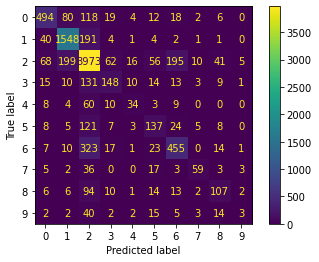

In [64]:
cm_display.plot()
plt.show()

# SGD Whole model

In [ ]:
optimizer = SGD(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

# we have unbalenced data
# whole model traning works much better